In [269]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np

from datetime                import datetime
from sklearn.metrics         import classification_report as cr 
from sklearn.metrics         import r2_score as r2
from sklearn.metrics         import accuracy_score as ac 
from sklearn.metrics         import mean_squared_error as mse
from sklearn.metrics         import confusion_matrix as cm
from sklearn.model_selection import train_test_split as tts

from sklearn.naive_bayes     import GaussianNB                 as GNB
from sklearn.naive_bayes     import MultinomialNB              as MNB
from sklearn.ensemble        import GradientBoostingClassifier as GBC 
from sklearn.ensemble        import RandomForestClassifier     as RFC
from sklearn.svm             import SVC                        as SVC
from sklearn.neighbors       import KNeighborsClassifier       as KNC
from sklearn.linear_model    import LogisticRegression         as LRE
from sklearn.linear_model    import LogisticRegressionCV       as LRC

In [246]:
df = pds.read_csv('insight-full.csv', header=0)
incoming_size = len(df)
df = df[(df['transport_code'].isnull()==False)  & (df['disp_problem_lvl'].isnull()==False) & 
        (df['latitude'].isnull()==False)        & (df['longitude'].isnull()==False) &
        (df['trans_score_mod'].isnull()==False) & (df['treat_score_mod'].isnull()==False) &
        (df['disp_problem_lvl']!='UNKNOWN')     & (df['age_yrs'].isnull()==False) &
        (df['sex'].isnull()==False)             & (df['sex']!='U') & (df['age_yrs']>0) &
        (df['disp_determinant/medical_code'].isnull()==False) &
        (df['disp_determinant/medical_code']!='XXXXX')]
df.index = range(len(df))
outgoing_size = len(df)
print('Read in {0} events, working with {1} events.'.format(incoming_size, outgoing_size))
print('{} cut events'.format(incoming_size-outgoing_size))

/home/chris/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in 342940 events, working with 315429 events.
27511 cut events


# Developing Classifications

How do we rate things as emergency or not?


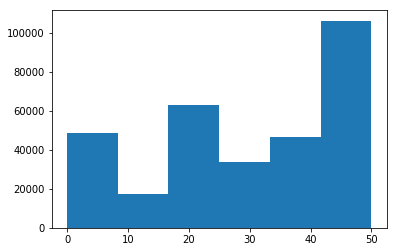

In [247]:
plt.hist(df['transport_code'],bins=6)
plt.show()

In [248]:
print(df['transport_code'].unique())

[30 50 20 40  0 10]


A level 10 transport code is an acute trama and needs the full response.  These should correspond to L1 response from the dispatcher

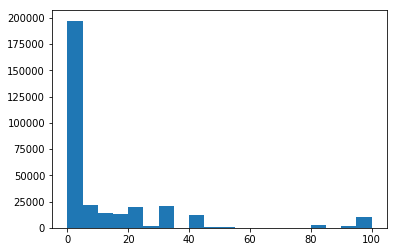

In [249]:
plt.hist(df['trans_score_mod'],bins=20)
plt.show()

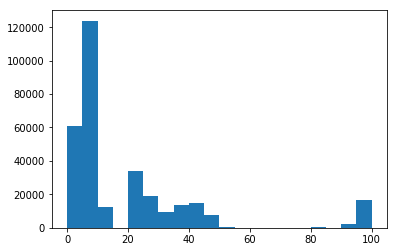

In [250]:
plt.hist(df['treat_score_mod'],bins=20)
plt.show()

## Classification from documentation
According to the document I was given classification should be:

Low:  treat: 0 - 20,     trans: 0 - 12

Med:  treat: 20 - 92.5,  trans: 12 - 90

High: treat: 92.5 - 100, trans: 90 - 100

The final classification is determined by the highest catagory

In [251]:
df['class'] = 0

df['class'][(df['treat_score_mod'] > 92.4) | (df['trans_score_mod'] > 89.9)] = 'L1'
df['class'][(df['treat_score_mod'] < 20)   & (df['trans_score_mod'] < 12)]   = 'L4'
df['class'][df['class']==0] = 'L3'

/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [253]:
df[['class','trans_score_mod','treat_score_mod']].head(15)

,class,trans_score_mod,treat_score_mod
0,L4,0.0,5.0
1,L4,2.0,5.0
2,L4,8.0,5.0
3,L4,2.0,5.0
4,L4,2.0,5.0
5,L4,2.0,10.0
6,L3,40.0,32.0
7,L4,2.0,5.0
8,L3,30.0,35.0
9,L4,2.0,5.0


## Classifications:

High = L1

Medium = L3

Low = L4

# Prepare Time Feature

Turn time of day into an float between 0 - 24 by the minute and bin into groups of 15 minutes.

In [254]:
df['response_date'] = df['response_date'].apply(lambda x: x.replace('.000', ''))
df['response_date'] = df['response_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time())
df['response_date'] = df['response_date'].apply(lambda x: x.hour+x.minute/60.)
df['response_date'].head(5)

0    16.233333
1    13.150000
2     8.483333
3    16.516667
4    19.516667
Name: response_date, dtype: float64

Time is in float types, need to bin the data.

In [255]:
# df['response_date'] = df['response_date'].apply(lambda x: int(x*4)/4.)
# df['response_date'].head(5)

## Time is formatted and binned

# Preparing sex

Need to change sex from M/F to 0/1

In [260]:
df['sex'] = df['sex'].apply(lambda x: 1 if 'F' else 0)

## Nothing could be simpler

# Choosing problems to work on

Only going to work on the biggest dispatch code to begin with.  I think this makes more sense than trying to do everything together.

In [261]:
code_list = list(df['disp_determinant/medical_code'].unique())
code_dict = {}
for i in range(len(code_list)):
    code_dict[code_list[i]] = i

In [262]:
for code in code_list:
    if len(df['disp_determinant/medical_code'][df['disp_determinant/medical_code']==code]) > 10000:
        print(code)

31D03
06D02
26D01
17B01
29B04


Creating a df for each of these so they don't get confused

In [263]:
df_31D03 = df[df['disp_determinant/medical_code']=='31D03']
df_06D02 = df[df['disp_determinant/medical_code']=='06D02']
df_26D01 = df[df['disp_determinant/medical_code']=='26D01']
df_17B01 = df[df['disp_determinant/medical_code']=='17B01']
df_29B04 = df[df['disp_determinant/medical_code']=='29B04']

## Have the problem sets

# What do I have?
Sex

Age

Time

Response

Class

# Let's get ready

In [270]:
train_06D02, test_06D02 = tts(df_06D02, test_size=0.2)
train_17B01, test_17B01 = tts(df_17B01, test_size=0.2)
train_26D01, test_26D01 = tts(df_26D01, test_size=0.2)
train_29B04, test_29B04 = tts(df_29B04, test_size=0.2)
train_31D03, test_31D03 = tts(df_31D03, test_size=0.2)

# Serialize Response Code

To use the dispatcher code it needs to be serialized, will use scikit and define a dictionary.

In [59]:
from sklearn.feature_extraction.text import CountVectorizer as CV

Need to define our dictionary

In [96]:
df['serial_code'] = 0
cv = CV()

In [97]:
cv.vocabulary = code_dict

In [98]:
df['serial_code'] = cv.fit_transform(df['disp_determinant/medical_code'])

In [117]:
from sklearn.preprocessing import OneHotEncoder  as OHE
from sklearn.preprocessing import LabelBinarizer as LBR
ohe = OHE()
lbr = LBR()

In [256]:
for code in code_dict:
    df['serial_code'][df['disp_determinant/medical_code']==code] = code_dict[code]

KeyError: 'serial_code'

In [118]:
test = pds.DataFrame()
test = lbr.fit_transform(df['disp_determinant/medical_code'])

In [143]:
print(test[0][0])

0


In [146]:
print(lbr.inverse_transform(1))

AttributeError: 'int' object has no attribute 'argmax'

In [124]:
from sklearn.naive_bayes import MultinomialNB as MNB

mnb = MNB()

In [125]:
mnb.fit(test,df['class'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [133]:
mnb.predict(test[[4,5,200]])

array([1, 1, 2])

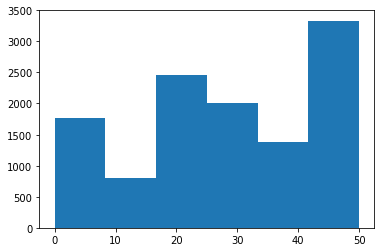

In [151]:
plt.hist(df['transport_code'][df['disp_determinant/medical_code']=='31D03'],bins=6)
plt.show()

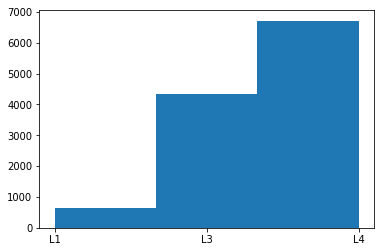

In [169]:
plt.hist(df['class'][df['disp_determinant/medical_code']=='31D03'],bins=3)
plt.show()

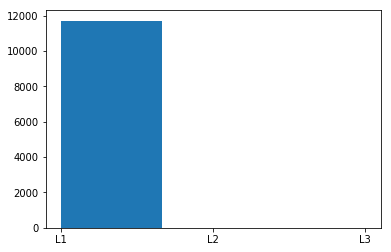

In [171]:
plt.hist(df['disp_problem_lvl'][df['disp_determinant/medical_code']=='31D03'], bins=3)
plt.show()

In [173]:
df['disp_dispatch_comment'].head(15)

0      [6] 72yof dizzy - fall; [7] [ProQA Script] Di...
1      [ProQA Script] Dispatch code: 28C01L  You are...
2      [5] [ProQA: Case Entry Complete]      75-year...
3      [9] [ProQA Script] Dispatch code: 26C01  You ...
4      [5] [ProQA: Case Entry Complete]      75-year...
5      [ProQA Script] Dispatch code: 01A01  You are ...
6      [6] [ProQA Script] Dispatch code: 30A01  You ...
7      [6] 75F - NOT EATING, CANT WALK - COVERED IN ...
8      [ProQA Script] Dispatch code: 10D04  You are ...
9      [ProQA Script] Dispatch code: 28C06L  You are...
10     75YO F.....; [ProQA Script] Dispatch code: 10...
11     [6] 76F -  ALC -  CONFUSED; [7] [ProQA: Case ...
12     [6] PT UNABLE TO VERIFY PHONE #; [7] [ProQA S...
13     [1] CELL SITE ADDRESS: 1402 K ST; [6] Chest p...
14     [6] [ProQA Script] Dispatch code: 10D02  You ...
Name: disp_dispatch_comment, dtype: object

In [176]:
str(df['disp_dispatch_comment'][8])

' [ProQA Script] Dispatch code: 10D04  You are responding to a patient with chest pain.  The patient is a 75-year-old  female, who is conscious and breathing. Clammy.'

In [188]:

gnb = GNB()

In [199]:
print(df['sex'][(df['sex']!='F') & (df['sex']!='M') & (df['sex']!='U')])

Series([], Name: sex, dtype: object)


In [210]:
print(df['sex'][df['sex']=='U'].count())

0


In [231]:
len(train)

252343

In [232]:
len(test)

63086

In [233]:
df[['age_yrs','gender','response_date']][(df['age_yrs']<0) | (df['response_date']<0) | (df['gender']<0) ]

,age_yrs,gender,response_date


In [234]:
model = mnb.fit(train[['age_yrs','gender','response_date']],train['class'])

In [236]:
pred = model.predict(test[['age_yrs','gender','response_date']])

In [238]:
print(cm(test['class'], pred))

[[    0   886  2374]
 [    0  5826 14386]
 [    0  9106 30508]]


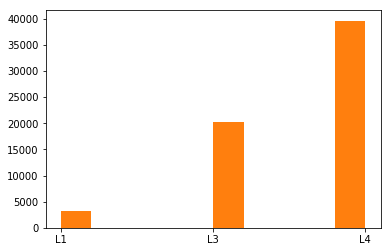

In [240]:
plt.hist(test['class'])
plt.show()

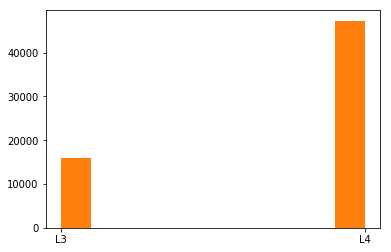

In [242]:
plt.hist(pred)
plt.show()

In [244]:
len(pred)

63086